Exploratory Data Analysis: Satellite Proxies for Economic Activity in Cuba

In this notebook, we will:
- Load and visualize NDVI and VIIRS nighttime lights raster files
- Check their spatial extents and alignment
- Generate summary statistics
- Visualize distributions and spatial patterns
"""

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.ndimage import gaussian_filter
import geopandas as gpd
from shapely.geometry import box
import contextily as cx
from rasterio.transform import xy
import matplotlib.pyplot as plt
from esda.moran import Moran
from libpysal.weights import lat2W
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np



In [4]:
ndvi_path = "/Users/chrisperez/Desktop/stat288-finalproject/data/dr_ndvi_2024.tif"
viirs_path = "/Users/chrisperez/Desktop/stat288-finalproject/data/dr_viirs_2024.tif"
road_path = "/Users/chrisperez/Desktop/stat288-finalproject/data/dr_osm_road_density_2024.tif"

In [5]:
def load_raster(path):
    with rasterio.open(path) as src:
        array = src.read(1)
        profile = src.profile
    return array, profile

In [6]:
ndvi_data, ndvi_meta = load_raster(ndvi_path)
viirs_data, viirs_meta = load_raster(viirs_path)
road_data, road_meta = load_raster(road_path)

In [7]:
summary_stats = pd.DataFrame({
    "NDVI": {
        "Min": np.nanmin(ndvi_data),
        "Max": np.nanmax(ndvi_data),
        "Mean": np.nanmean(ndvi_data),
        "Std": np.nanstd(ndvi_data)
    },
    "VIIRS": {
        "Min": np.nanmin(viirs_data),
        "Max": np.nanmax(viirs_data),
        "Mean": np.nanmean(viirs_data),
        "Std": np.nanstd(viirs_data)
    },
    "Roads": {
        "Min": np.nanmin(road_data),
        "Max": np.nanmax(road_data),
        "Mean": np.nanmean(road_data),
        "Std": np.nanstd(road_data)
    }
})
summary_stats.T

,Min,Max,Mean,Std
NDVI,-0.143500,0.908235,0.715028,0.119376
VIIRS,0.230909,205.110916,1.857790,6.153409
Roads,0.076923,1.000000,0.689884,0.206211


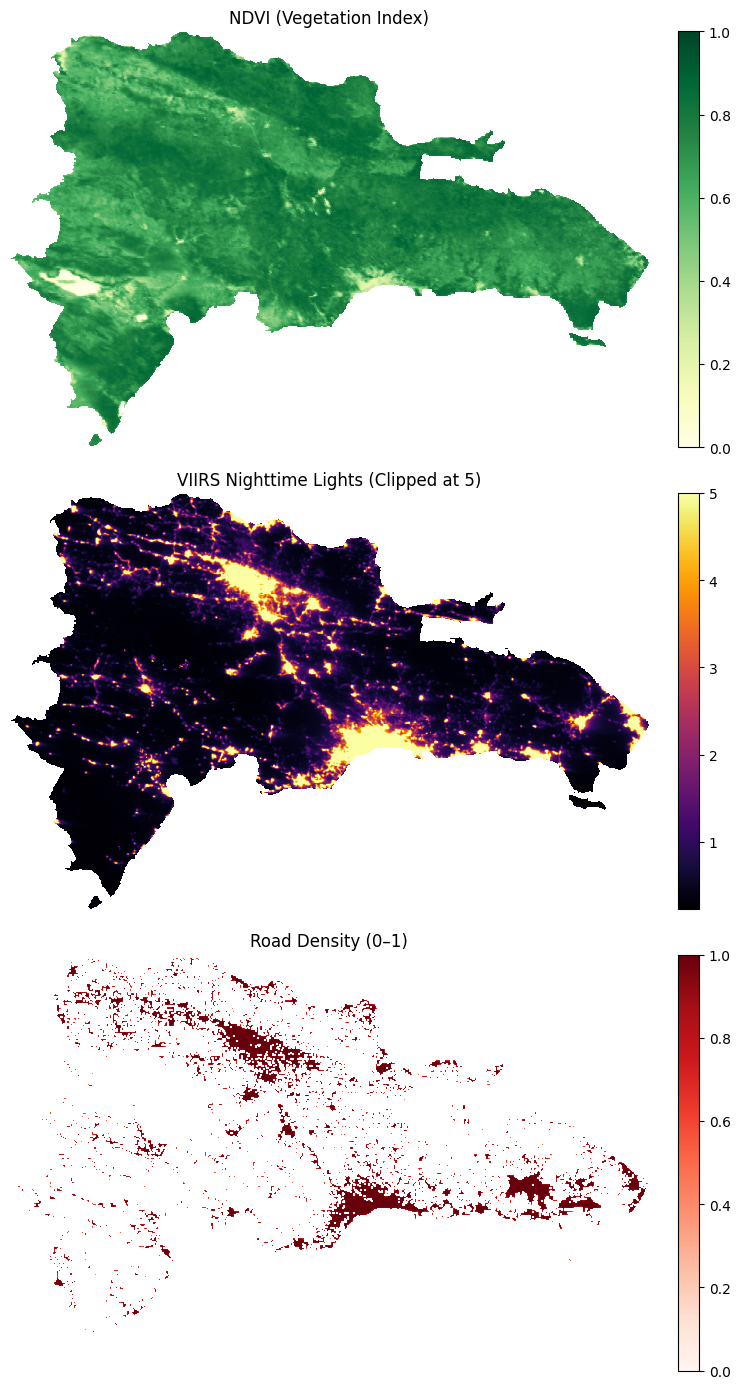

In [8]:
# Plot the three maps vertically for a clear comparison

fig, axes = plt.subplots(3, 1, figsize=(8, 14))

# NDVI
im1 = axes[0].imshow(ndvi_data, cmap='YlGn', vmin=0, vmax=1)
axes[0].set_title('NDVI (Vegetation Index)')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
axes[0].axis('off')

# VIIRS Nighttime Lights
im2 = axes[1].imshow(np.clip(viirs_data, 0, 5), cmap='inferno')
axes[1].set_title('VIIRS Nighttime Lights (Clipped at 5)')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
axes[1].axis('off')

# Road Density
im3 = axes[2].imshow(road_data, cmap='Reds', vmin=0, vmax=1)
axes[2].set_title('Road Density (0–1)')
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
axes[2].axis('off')

plt.tight_layout()
plt.show()


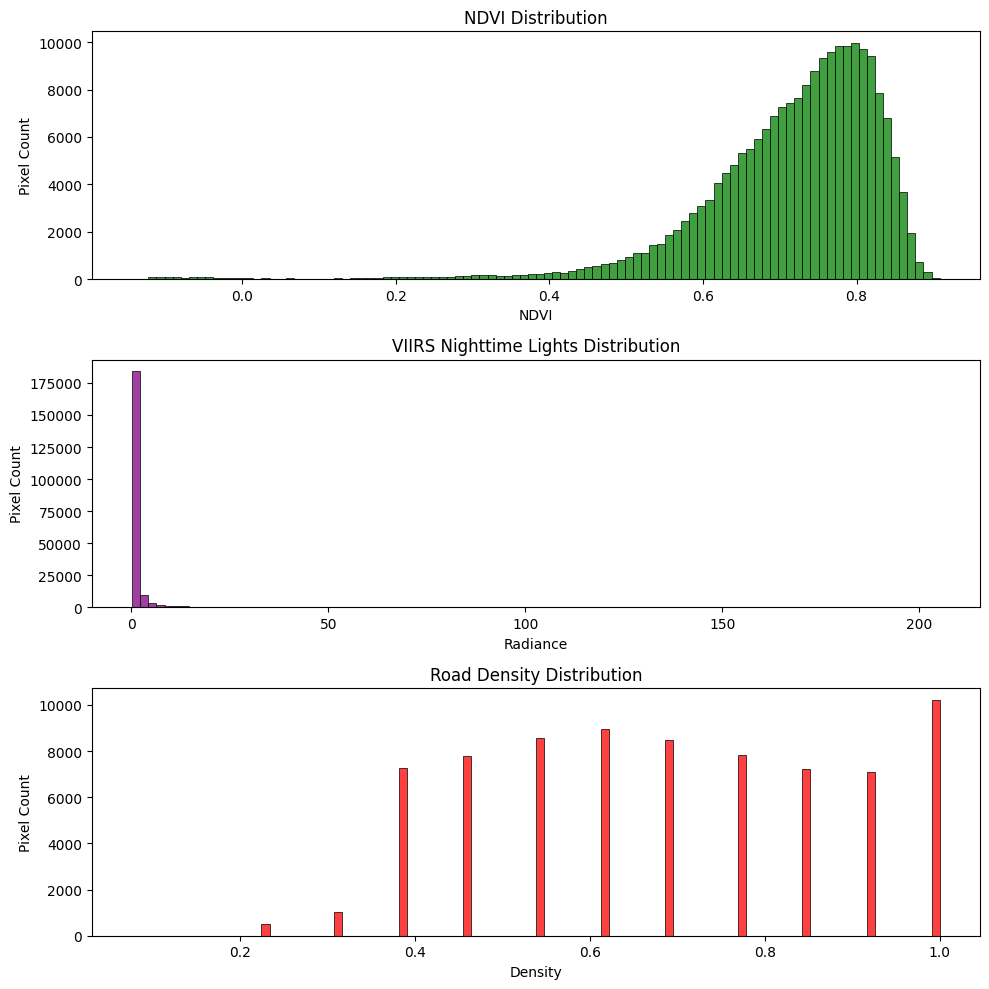

In [9]:
# Plot histograms of all three data sources vertically

fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# NDVI Histogram
sns.histplot(ndvi_data[np.isfinite(ndvi_data)], bins=100, ax=axes[0], color='green')
axes[0].set_title('NDVI Distribution')
axes[0].set_xlabel('NDVI')
axes[0].set_ylabel('Pixel Count')

# VIIRS Histogram
sns.histplot(viirs_data[np.isfinite(viirs_data)], bins=100, ax=axes[1], color='purple')
axes[1].set_title('VIIRS Nighttime Lights Distribution')
axes[1].set_xlabel('Radiance')
axes[1].set_ylabel('Pixel Count')

# Road Density Histogram
sns.histplot(road_data[np.isfinite(road_data)], bins=100, ax=axes[2], color='red')
axes[2].set_title('Road Density Distribution')
axes[2].set_xlabel('Density')
axes[2].set_ylabel('Pixel Count')

plt.tight_layout()
plt.show()


SECTION: CORRELATIONS BETWEEN PROXIES

In [10]:
valid_mask = (
    np.isfinite(ndvi_data) &
    np.isfinite(viirs_data) &
    np.isfinite(road_data)
)

ndvi_vals = ndvi_data[valid_mask]
viirs_vals = viirs_data[valid_mask]
road_vals = road_data[valid_mask]

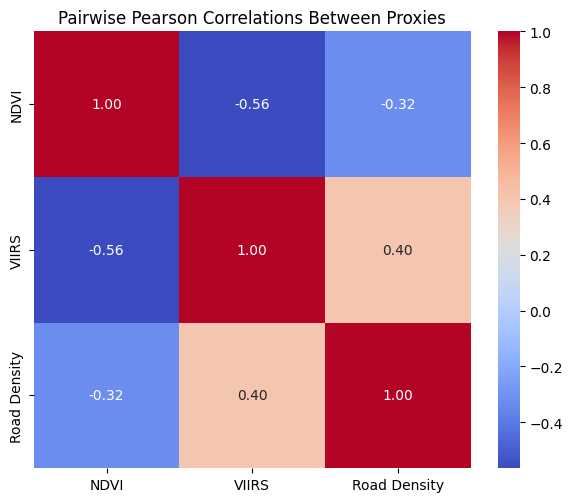

In [11]:
# Compute pairwise Pearson correlations
ndvi_viirs_corr = np.corrcoef(ndvi_vals, viirs_vals)[0, 1]
ndvi_road_corr = np.corrcoef(ndvi_vals, road_vals)[0, 1]
viirs_road_corr = np.corrcoef(viirs_vals, road_vals)[0, 1]

# Create a heatmap-style matrix of these
corr_df = pd.DataFrame({
    "NDVI": [1.0, ndvi_viirs_corr, ndvi_road_corr],
    "VIIRS": [ndvi_viirs_corr, 1.0, viirs_road_corr],
    "Road Density": [ndvi_road_corr, viirs_road_corr, 1.0]
}, index=["NDVI", "VIIRS", "Road Density"])

# Plot the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pairwise Pearson Correlations Between Proxies")
plt.tight_layout()
plt.show()

QUESTION: WHERE DO THE PROXIES DISAGREE?

/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


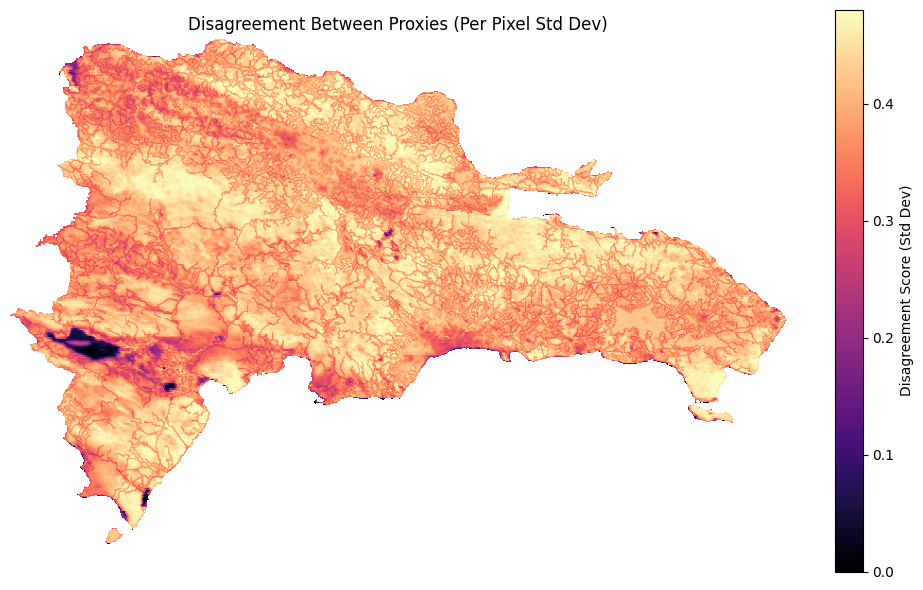

In [12]:
# Step 1: Normalize all layers to [0, 1] for fair comparison
ndvi_norm = (ndvi_data - np.nanmin(ndvi_data)) / (np.nanmax(ndvi_data) - np.nanmin(ndvi_data))
viirs_norm = (viirs_data - np.nanmin(viirs_data)) / (np.nanmax(viirs_data) - np.nanmin(viirs_data))
road_norm = (road_data - np.nanmin(road_data)) / (np.nanmax(road_data) - np.nanmin(road_data))

# Step 2: Compute disagreement score: high variance among the three proxies per pixel
stacked = np.stack([ndvi_norm, viirs_norm, road_norm], axis=0)
disagreement = np.nanstd(stacked, axis=0)  # standard deviation per pixel

# Step 3: Visualize disagreement map
plt.figure(figsize=(10, 6))
plt.imshow(disagreement, cmap='magma', vmin=0, vmax=np.nanpercentile(disagreement, 99))
plt.title('Disagreement Between Proxies (Per Pixel Std Dev)')
plt.colorbar(label='Disagreement Score (Std Dev)')
plt.axis('off')
plt.tight_layout()
plt.show()

The above heatmap tells us that for brighter pixels, there is greater disagreement between the proxies. And for darker pxels, the proxies agree (either all are high or all are low). 

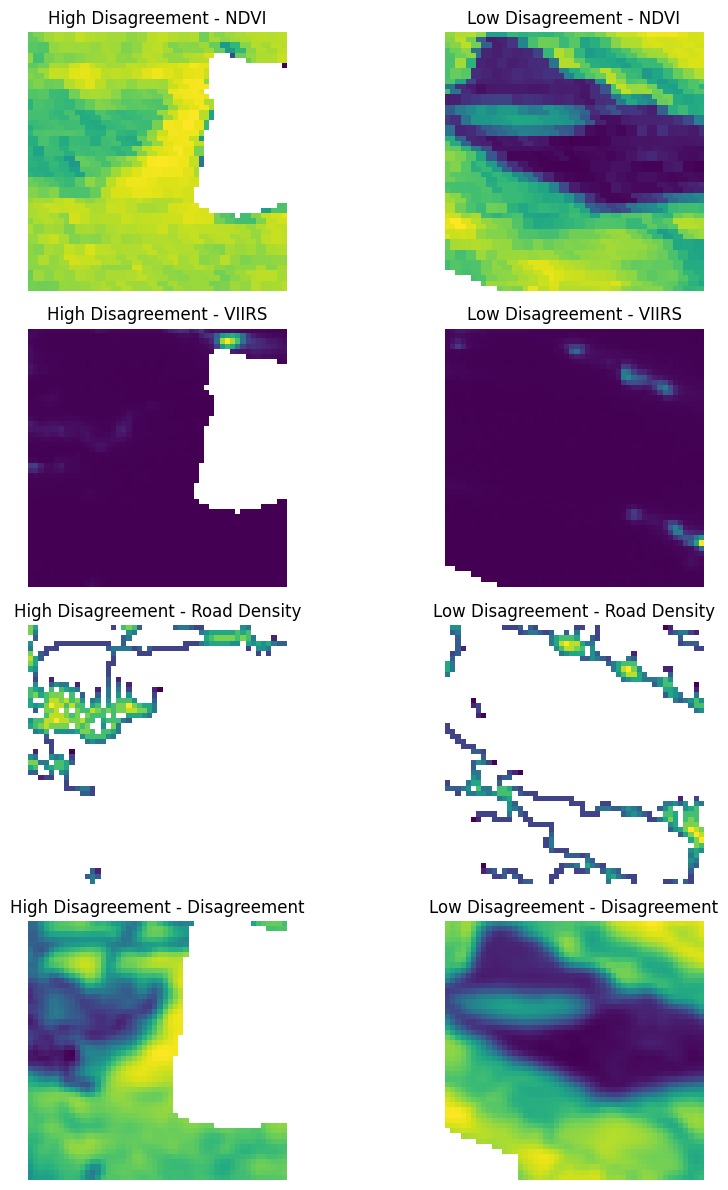

In [13]:
# Smooth the disagreement map slightly to reduce noise
smoothed_disagreement = gaussian_filter(disagreement, sigma=1)

# Find max and min disagreement pixel indices
max_idx = np.unravel_index(np.nanargmax(smoothed_disagreement), smoothed_disagreement.shape)
min_idx = np.unravel_index(np.nanargmin(smoothed_disagreement), smoothed_disagreement.shape)

# Define a window size for zooming in (e.g., 50x50 pixels)
window = 50

def crop_around(img, center, window):
    i, j = center
    return img[i-window//2:i+window//2, j-window//2:j+window//2]

# Crop all layers for both regions
layers = {
    "NDVI": ndvi_norm,
    "VIIRS": viirs_norm,
    "Road Density": road_norm,
    "Disagreement": smoothed_disagreement
}

zoom_high = {name: crop_around(data, max_idx, window) for name, data in layers.items()}
zoom_low = {name: crop_around(data, min_idx, window) for name, data in layers.items()}

# Plot zoomed-in areas side by side
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
for i, name in enumerate(["NDVI", "VIIRS", "Road Density", "Disagreement"]):
    axes[i, 0].imshow(zoom_high[name], cmap='viridis')
    axes[i, 0].set_title(f'High Disagreement - {name}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(zoom_low[name], cmap='viridis')
    axes[i, 1].set_title(f'Low Disagreement - {name}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Helper function to convert pixel indices to lat/lon bounds
def pixel_to_bounds(transform, center_idx, window_size):
    row, col = center_idx
    half_win = window_size // 2

    top_left = (row - half_win, col - half_win)
    bottom_right = (row + half_win, col + half_win)

    lon_min, lat_max = xy(transform, top_left[0], top_left[1])
    lon_max, lat_min = xy(transform, bottom_right[0], bottom_right[1])

    return box(lon_min, lat_min, lon_max, lat_max)

/var/folders/dt/0bnsl48d14n491d2_r6d8fvw0000gn/T/ipykernel_59489/1264693339.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


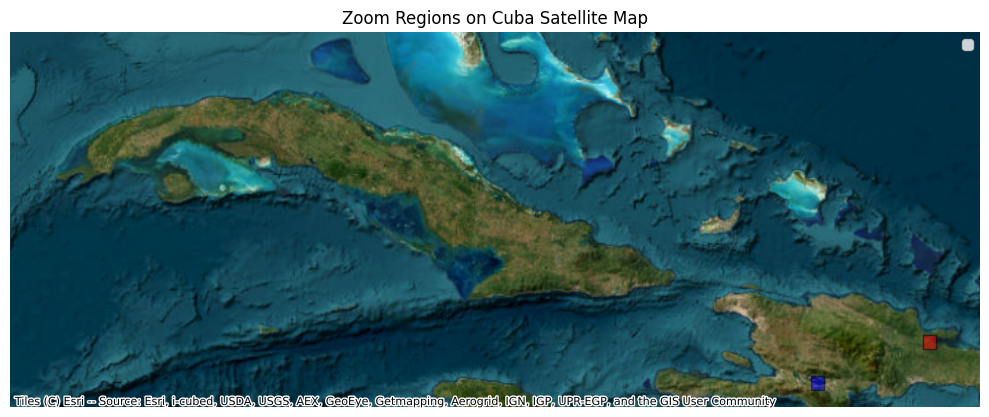

In [15]:
transform = road_meta['transform']
window_size = 50

# Get bounding boxes as shapely Polygons
high_box = pixel_to_bounds(transform, max_idx, window_size)
low_box = pixel_to_bounds(transform, min_idx, window_size)

# Convert to GeoDataFrames
high_gdf = gpd.GeoDataFrame({'Region': ['High Disagreement']}, geometry=[high_box], crs='EPSG:4326')
low_gdf = gpd.GeoDataFrame({'Region': ['Low Disagreement']}, geometry=[low_box], crs='EPSG:4326')

# Plot both on a Cuba basemap
fig, ax = plt.subplots(figsize=(10, 8))
base = gpd.GeoSeries(box(-85, 19, -74, 24), crs='EPSG:4326').plot(ax=ax, edgecolor='none', alpha=0) 

# Plot both boxes
high_gdf.plot(ax=base, color='red', alpha=0.5, edgecolor='black', label='High Disagreement')
low_gdf.plot(ax=base, color='blue', alpha=0.5, edgecolor='black', label='Low Disagreement')

cx.add_basemap(ax, crs=high_gdf.crs, source=cx.providers.Esri.WorldImagery)

ax.set_title("Zoom Regions on Cuba Satellite Map")
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()

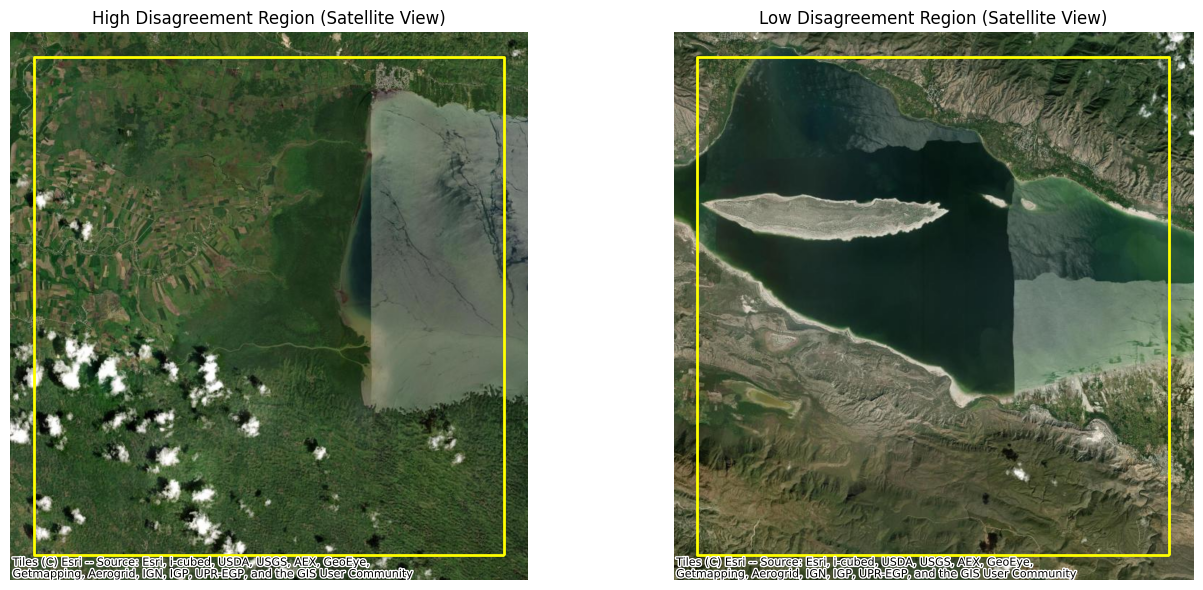

In [16]:
# Rebuild bounding boxes
transform = road_meta['transform']
high_box = pixel_to_bounds(transform, max_idx, 50)
low_box = pixel_to_bounds(transform, min_idx, 50)

# Make GeoDataFrames
high_gdf = gpd.GeoDataFrame({'Region': ['High Disagreement']}, geometry=[high_box], crs='EPSG:4326')
low_gdf = gpd.GeoDataFrame({'Region': ['Low Disagreement']}, geometry=[low_box], crs='EPSG:4326')

# Plot satellite basemap with zoom boxes
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for ax, gdf, title in zip(axs, [high_gdf, low_gdf], ['High Disagreement', 'Low Disagreement']):
    gdf.to_crs(epsg=3857).plot(ax=ax, color='none', edgecolor='yellow', linewidth=2)
    cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)
    ax.set_title(f"{title} Region (Satellite View)")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

SPATIAL AUTOCORRELATION? 

In [17]:
# Fill NaNs with 0 (or the mean/median if you're worried about bias)
ndvi_filled = np.nan_to_num(ndvi_data, nan=0)
viirs_filled = np.nan_to_num(viirs_data, nan=0)
road_filled = np.nan_to_num(road_data, nan=0)

# Flatten
ndvi_flat = ndvi_filled.flatten()
viirs_flat = viirs_filled.flatten()
road_flat = road_filled.flatten()

# Create spatial weights (full grid)
rows, cols = ndvi_data.shape
w = lat2W(rows, cols)

moran_ndvi = Moran(ndvi_flat, w)
moran_viirs = Moran(viirs_flat, w)
moran_road = Moran(road_flat, w)

import pandas as pd

# Store results
moran_df = pd.DataFrame({
    "Moran's I": [moran_ndvi.I, moran_viirs.I, moran_road.I],
    "p-value": [moran_ndvi.p_sim, moran_viirs.p_sim, moran_road.p_sim]
}, index=["NDVI", "VIIRS", "Road Density"])

moran_df

,Moran's I,p-value
NDVI,0.990178,0.001
VIIRS,0.948397,0.001
Road Density,0.799174,0.001


Here I am looking out for spatial autocorrelation, which refers to the degree to which a variable is correlated with itself across space—whether high or low values tend to cluster together geographically. Moran’s I is a commonly used statistic to measure global spatial autocorrelation, ranging from -1 (perfect dispersion) to +1 (perfect clustering), with 0 indicating a random spatial pattern. 

Above, we see strong positive spatial autocorrelation for all three layers: NDVI (0.99), VIIRS Nighttime Lights (0.74), and Road Density (0.76), each with a statistically significant p-value of 0.001. These results indicate that high and low values of each proxy are spatially clustered rather than randomly distributed.
--> Provides strong justification for modeling spatial smoothness in our latent economic activity model, perhaphs through a GMRF prior.